# PREDIÇÃO PARA MORTES POR COVID

#### IMPORTAÇÕES

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime
import math
from IPython.display import display, Markdown, Image
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy import stats
from scipy.stats import pearsonr
import random
import warnings

from pickle import dump

# IMPORT REDES NEURAIS
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
import sklearn
sklearn.__version__

'0.23.1'

In [3]:
tf.__version__

'2.1.0'

#### FUNÇÕES

### Função para cálculo do Fator de 2

In [4]:
def get_fac2(y_true, y_pred):
    min_ = 0.5
    max_ = 2
    
    eps = np.finfo(np.float).eps
    
    division = y_pred / (y_true+eps)
    
    greater_min = np.greater_equal(division, min_)
    less_max = np.less_equal(division, max_)

    res = np.equal(greater_min, less_max)
    res = res.astype(float)

    fac_2 = res.mean()

    return fac_2

In [5]:
def plot_samples(y_true, y_pred, title='', xlabel='', ylabel='', filename="LSTMCNN"):
    
    plt.figure(figsize=(14, 18))
    plt.suptitle(title, fontsize=14, y=0.915)
    
    n_cols = y_true.shape[1]
    
    for col in range(n_cols):
        
        days = list(range(col+1, (col+1)+len(y_true)))
        
        plt.subplot(8, 4, col+1)
        plt.title('Previsões para t+{}'.format(col+1))
        plt.plot(days, y_true.iloc[:, col], label='Real')
        plt.plot(days, y_pred.iloc[:, col], label='Previsão')
        plt.legend()
        plt.xlabel(xlabel, fontsize=10)
        plt.ylabel(ylabel, fontsize=10)
        plt.xlim(left=days[0], right=days[-1])
        plt.xticks(np.linspace(days[0], days[-1], num=5, dtype=int))
    plt.tight_layout()    
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
#     plt.savefig(filename +"_plot_samples.png", dpi=600)
    plt.show()
    
def plot_scatter(y_true, y_pred, title='', filename="LSTMCNN"):
    
    plt.figure(figsize=(14, 18))
    plt.suptitle(title, fontsize=14, y=0.915)
    
    n_cols = y_true.shape[1]
    
    for col in range(n_cols):
        
        max_val = max(y_true.iloc[:, col].max(), y_pred.iloc[:, col].max())
        min_val = min(y_true.iloc[:, col].min(), y_pred.iloc[:, col].min())
                
        max_lim = max_val + max_val*0.05
        max_lim = math.ceil(max_lim)
        
        ndigits = len(str(max_lim))
        max_lim = int(math.ceil(max_lim / (10.0**(ndigits-2)) )) * (10.0**(ndigits-2))
        
        min_lim = min_val - max_val*0.05
        min_lim = max(0, min_lim)
        
        plt.subplot(8, 4, col+1)
        plt.title('Previsões para t+{}'.format(col+1))
        plt.scatter(y_true.iloc[:, col], y_pred.iloc[:, col])
        plt.xlabel('Real', fontsize=10)
        plt.ylabel('Previsão', fontsize=10)
        
        plt.xlim(left=min_lim, right=max_lim)
        plt.ylim(top=max_lim, bottom=min_lim)
        
        plt.xticks(np.linspace(min_lim, max_lim, num=5, dtype=int))
        plt.yticks(np.linspace(min_lim, max_lim, num=5, dtype=int))

        plt.plot([min_lim, max_lim], [min_lim, max_lim])
   
    plt.tight_layout()       
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
#     plt.savefig(filename + "_plot_scatter.png", dpi=600)
    plt.show()
    
def get_metrics(y_true, y_pred, filename="LSTMCNN"):
    
    metrics = pd.DataFrame(columns=['MSE', 'RMSE', 'MAE', 'Pearson r', 'Fac2'])
    
    n_cols = y_true.shape[1]
    
    for col in range(n_cols):
        y_true_col = y_true.iloc[:, col]
        y_pred_col = y_pred.iloc[:, col]

        if y_true_col.name == y_pred_col.name:
            col_name = y_true_col.name
        else:
            print('Column name error.')
            return None

        mse = mean_squared_error(y_true_col, y_pred_col)
        rmse = mean_squared_error(y_true_col, y_pred_col, squared=False)
        mae = mean_absolute_error(y_true_col, y_pred_col)
        pearson_r = pearsonr(y_true_col, y_pred_col)[0]
        fac2 = get_fac2(y_true_col.values, y_pred_col.values)
        metrics.loc[col_name, :] = [mse, rmse, mae, pearson_r, fac2]

    metrics.loc['Average', :] = metrics.mean()
#     metrics.to_csv("csv_metrics/" + filename + "_Metricas.csv",index=False)
    return metrics

def plot_metrics(dict_metrics, title='', xlabel='', ylabel='', filename="LSTM"):
    
    plt.figure(figsize=(14, 12))
    plt.suptitle(title, fontsize=14, y=0.935)
    
    keys = list(dict_metrics.keys())
    key_0 = keys[0]
    metrics_df_0 = dict_metrics[key_0]
    metrics_names = metrics_df_0.columns
    time_steps = list(range(1, metrics_df_0.shape[0]))
    
    for col, metric_name in enumerate(metrics_names):
        
        plt.subplot(3, 2, col+1)
        
        for key in dict_metrics.keys():
            
            metrics_df = dict_metrics[key]
            plt.plot(time_steps, metrics_df.iloc[0:-1, col], marker='o', label=key)
        
        plt.title('{} para cada horizonte de previsão'.format(metric_name))
        plt.legend()
        plt.xlabel('Dias a frente', fontsize=10)
        plt.ylabel(metric_name, fontsize=10)
        plt.xlim(left=time_steps[0], right=time_steps[-1])
        plt.xticks(np.linspace(time_steps[0], time_steps[-1], num=5, dtype=int))
        
        
    plt.subplots_adjust(wspace=0.2, hspace=0.4)
#     plt.savefig(filename + "_plot_scatter.png", dpi=600)
    plt.show()

In [6]:
def generate_single_region_dataset(key, region_data, look_back, look_forward, x_columns, y_columns=None, gen_x=True, gen_y=True):
    
    # Check region dataframe
    if region_data is None:
        print('generate_single_region_dataset error: Region data is None!')
        return (None, None)
    
    # Check number of regions
    if len(region_data[key].unique()) > 1:
        print('generate_single_region_dataset error: More than one region in the dataframe!')
        return (None, None)
    else:
        region_name = region_data[key].unique()[0]
    
    # Drop 'Region' column
    region_data = region_data.drop(columns=key)
    
    # Check the number of samples available to
    # generate the look back and look forward windows
    if len(region_data) < (look_back + look_forward):
        print('generate_single_region_dataset error: Not enough samples '+
              'in {} to generate the windows!'.format(region_name))
        return (None, None)
    
    n_samples = len(region_data) - look_back - look_forward + 1

    var_names = x_columns
    
    # Generate inputs
    if gen_x:
        inputs = pd.DataFrame()
        
        for i in range(n_samples):
            input_window = region_data.T.iloc[:, i:i+look_back]
            wide_input_sample = pd.DataFrame()
            
            for var in var_names:
                var_input_sample = input_window.loc[var:var, :]
                var_input_sample.columns = ['{}_t{}'.format(var, a) for a in range(1-look_back, 1)]
                var_input_sample = var_input_sample.reset_index(drop=True)
                wide_input_sample = pd.concat([wide_input_sample, var_input_sample], axis='columns')
                
            inputs = pd.concat([inputs, wide_input_sample], axis='index')
            
        # Insert region name
        #inputs.insert(loc=0, column=key, value=region_name)
        # Reset index
        inputs = inputs.reset_index(drop=True)

    # Generate outputs
    if gen_y:
        
        if y_columns is None:
            print('generate_single_region_dataset error: Need to specify column labels!')
            return (None, None)
        
        var_names = y_columns
        outputs = pd.DataFrame()
        
        for i in range(n_samples):
            output_window = region_data.T.iloc[:, i+look_back : i+look_back+look_forward]
            wide_output_sample = pd.DataFrame()

            for var in var_names:
                var_output_sample = output_window.loc[var:var, :]
                var_output_sample.columns = ['{}_t+{}'.format(var, a) for a in range(1, look_forward+1)]
                var_output_sample = var_output_sample.reset_index(drop=True)
                wide_output_sample = pd.concat([wide_output_sample, var_output_sample], axis='columns')

            outputs = pd.concat([outputs, wide_output_sample], axis='index')
        
        # Insert region name
        #outputs.insert(loc=0, column=key, value=region_name)
        # Reset index
        outputs = outputs.reset_index(drop=True)
        
    if gen_x and gen_y:
        return (inputs, outputs)
    elif gen_x:
        return (inputs, None)
    elif gen_y:
        return (None, outputs)

In [7]:
def generate_regions_dataset(key, regions_data, look_back, look_forward, x_columns, y_columns=None, 
                             gen_x=True, gen_y=True):
    
    regions_names = regions_data[key].unique()
    
    all_regions_x = pd.DataFrame()
    all_regions_y = pd.DataFrame()
    
    for region_name in regions_names:
        
        region_data = regions_data[regions_data[key]==region_name]
        
        region_x, region_y = generate_single_region_dataset(key,
            region_data, look_back=look_back, look_forward=look_forward, x_columns=x_columns, y_columns=y_columns,
            gen_x=gen_x, gen_y=gen_y
        )
        
        if not (region_x is None):
            all_regions_x = pd.concat([all_regions_x, region_x])
            all_regions_x = all_regions_x.reset_index(drop=True)
            
        if not (region_y is None):
            all_regions_y = pd.concat([all_regions_y, region_y])
            all_regions_y = all_regions_y.reset_index(drop=True)
    
    if gen_x and gen_y:
        return (all_regions_x, all_regions_y)
    elif gen_x:
        return (all_regions_x, None)
    elif gen_y:
        return (None, all_regions_y)

In [8]:
lookback = 4
lookforward= 30

#### LEITURA DOS DADOS DO GRUPO

In [9]:
nome_arquivo_analise = "../dataset/train_mundial_estadual_model_20200814.csv"

train_data = pd.read_csv(nome_arquivo_analise, sep="," , decimal=".")

In [10]:
val_data = pd.read_csv("../dataset/val_mundial_estadual_model_20200814.csv", sep="," , decimal=".")

In [11]:
test_data = pd.read_csv("../dataset/test_mundial_estadual_model_20200814.csv", sep="," , decimal=".")

#### ETAPA TRADICIONAL TRAIN/VAL/TEST

In [12]:
x_columns = ["Deaths", "Confirmed", "C1","C2","C3","C4","C5","C6","C7","C8"]
y_columns = ["Deaths"]

train_x, train_y = generate_regions_dataset("Country/Region", train_data, lookback, lookforward, x_columns, y_columns=y_columns)
val_x, val_y = generate_regions_dataset("Country/Region", val_data, lookback, lookforward, x_columns, y_columns=y_columns)
test_x, test_y = generate_regions_dataset("Country/Region", test_data, lookback, lookforward, x_columns, y_columns=y_columns)

In [13]:
normalizador = MinMaxScaler(feature_range=(0, 1))
norm_dados_treino_full = normalizador.fit_transform(train_x)
norm_dados_test = normalizador.transform(test_x)
norm_dados_val = normalizador.transform(val_x)

normalizador_y = MinMaxScaler(feature_range=(0, 1))
y_train = normalizador_y.fit_transform(train_y)
y_test = normalizador_y.transform(test_y)
y_val = normalizador_y.transform(val_y)

In [14]:
new_train = np.empty([norm_dados_treino_full.shape[0], lookback, len(x_columns)])
new_test = np.empty([norm_dados_test.shape[0], lookback, len(x_columns)])
new_val = np.empty([norm_dados_val.shape[0], lookback, len(x_columns)])

In [15]:
k = 0
for i in range(len(x_columns)):
    for j in range(lookback):
        new_train[:, j, i] = norm_dados_treino_full[:, k]
        k = k + 1

In [16]:
k = 0
for i in range(len(x_columns)):
    for j in range(lookback):
        new_val[:, j, i] = norm_dados_val[:, k]
        k = k + 1

In [17]:
k = 0
for i in range(len(x_columns)):
    for j in range(lookback):
        new_test[:, j, i] = norm_dados_test[:, k]
        k = k + 1

In [18]:
#Arquitetura da RNA
activation = 'relu'
opt = optimizers.Adamax()
#opt = optimizers.RMSprop(lr=1e-5)

tf.random.set_seed(0)

modelo = Sequential()
modelo.add(Conv1D(filters=40, kernel_size=2, padding='same', activation= 'tanh',
                  input_shape = (new_train.shape[1],new_train.shape[2])))
#modelo.add(MaxPooling1D(pool_size=5, padding='same'))
modelo.add(Conv1D(filters=40, kernel_size=2, padding='same', activation= 'tanh'))
#modelo.add(Conv1D(filters=40, kernel_size=100, padding='same', activation= 'relu'))
modelo.add(MaxPooling1D(pool_size=2, padding='same'))


modelo.add(LSTM(units = 60, return_sequences = True, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)) )
#modelo.add(LSTM(units = 100, input_shape = (norm_dados_treino_full.shape[1],norm_dados_treino_full.shape[2]), activation='tanh'))
modelo.add(Dropout(0.1))
modelo.add(LSTM(units = 60, return_sequences = True, activation='tanh'))
modelo.add(LSTM(units = 60, activation = 'relu'))
#modelo.add(Dense(units = 300, input_shape = norm_dados_treino_full.shape, activation = 'relu'))
#modelo.add(Dense(units = 60, activation = 'relu'))
#modelo.add(Dense(units = 60, activation = 'tanh'))
#modelo.add(Dense(units = 60, activation = 'relu'))
#modelo.add(Dense(units = 300, activation = 'relu'))
modelo.add(Dense(units = lookforward, activation = 'linear'))

modelo.compile(optimizer=opt, loss='mse')

history = modelo.fit(new_train, y_train, validation_data=(new_val, y_val), shuffle=False ,batch_size = 1000, epochs = 163, verbose=1)

Train on 8196 samples, validate on 7263 samples
Epoch 1/163
8196/8196 [==============================] - 5s 668us/sample - loss: 0.6366 - val_loss: 0.5655
Epoch 2/163
8196/8196 [==============================] - 1s 84us/sample - loss: 0.5285 - val_loss: 0.4687
Epoch 3/163
8196/8196 [==============================] - 1s 76us/sample - loss: 0.4385 - val_loss: 0.3884
Epoch 4/163
8196/8196 [==============================] - 1s 70us/sample - loss: 0.3640 - val_loss: 0.3220
Epoch 5/163
8196/8196 [==============================] - 1s 79us/sample - loss: 0.3025 - val_loss: 0.2673
Epoch 6/163
8196/8196 [==============================] - 1s 66us/sample - loss: 0.2517 - val_loss: 0.2221
Epoch 7/163
8196/8196 [==============================] - 0s 54us/sample - loss: 0.2098 - val_loss: 0.1848
Epoch 8/163
8196/8196 [==============================] - 0s 54us/sample - loss: 0.1751 - val_loss: 0.1539
Epoch 9/163
8196/8196 [==============================] - 0s 59us/sample - loss: 0.1464 - val_loss: 0.12

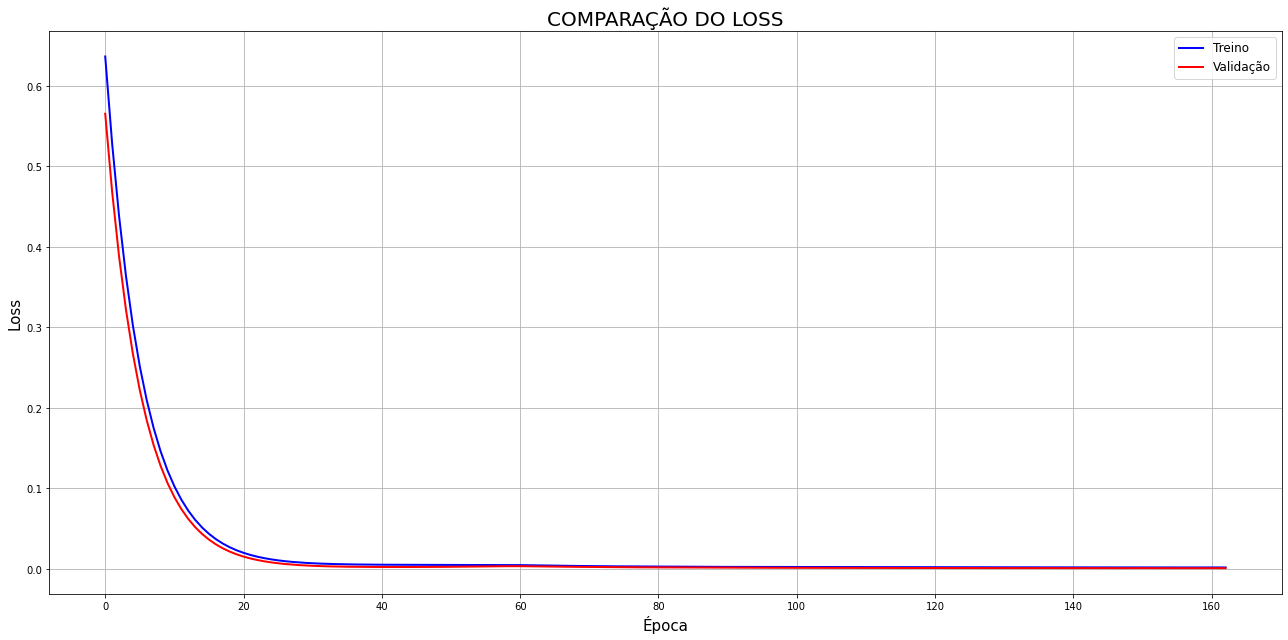

In [19]:
plt.figure(figsize=(18,9))

plt.plot(history.history['loss'], label = "Treino", linewidth =2, color ='blue')        
plt.plot(history.history['val_loss'],'-', label = "Validação", linewidth =2, color='red')

plt.title('COMPARAÇÃO DO LOSS', fontsize =20)
plt.xlabel('Época', fontsize =15)
plt.ylabel('Loss',fontsize =15)
plt.grid()
plt.legend(fontsize=12)
plt.tight_layout()
# plt.savefig("SEM_INFERENCIA_CONFIRMED_LSTMCNN_Grafico_de_loss.png", dpi=600)
plt.show()

In [20]:
warnings.filterwarnings('ignore')
y_train_pred =  modelo.predict(new_train) 
y_train_pred = normalizador_y.inverse_transform(y_train_pred)
train_y = normalizador_y.inverse_transform(y_train)


y_train_pred = pd.DataFrame(y_train_pred)
train_y = pd.DataFrame(train_y)

train_metrics = get_metrics(train_y, y_train_pred)

In [21]:
warnings.filterwarnings('ignore')
y_test_pred =  modelo.predict(new_test) 
y_test_pred = normalizador_y.inverse_transform(y_test_pred)
test_y = normalizador_y.inverse_transform(y_test)
y_test_pred = pd.DataFrame(y_test_pred)
test_y = pd.DataFrame(test_y)

test_metrics = get_metrics(test_y, y_test_pred)

In [22]:
warnings.filterwarnings('ignore')
y_val_pred =  modelo.predict(new_val) 
y_val_pred = normalizador_y.inverse_transform(y_val_pred)
val_y = normalizador_y.inverse_transform(y_val)
y_val_pred = pd.DataFrame(y_val_pred)
val_y = pd.DataFrame(val_y)

val_metrics = get_metrics(val_y, y_val_pred)

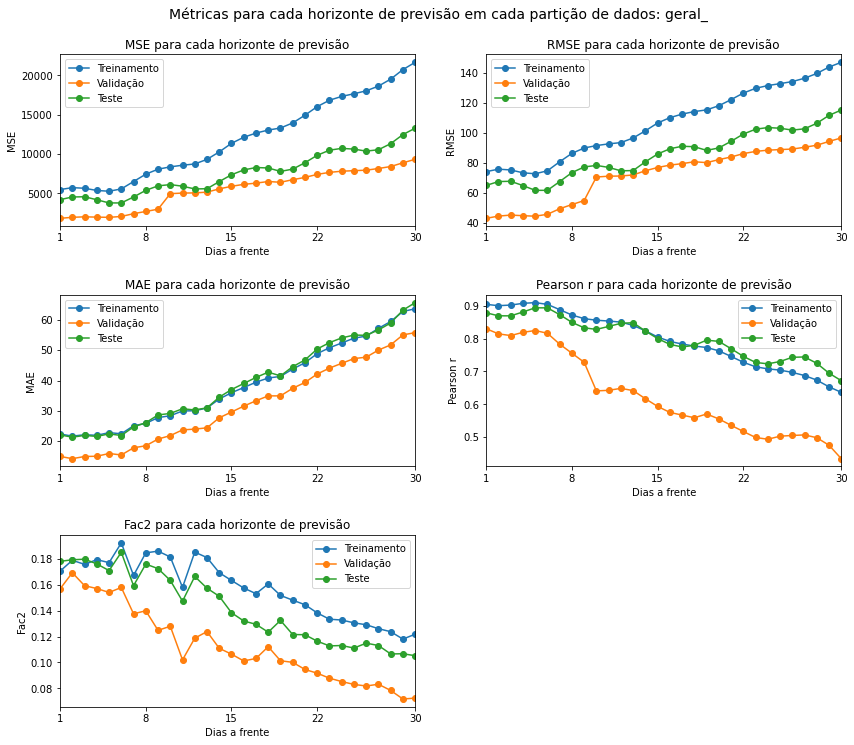

In [23]:
local="geral_"
dict_metrics = {
    'Treinamento': train_metrics,
    'Validação': val_metrics,
    'Teste': test_metrics
}
plot_metrics(
    dict_metrics,
    title='Métricas para cada horizonte de previsão em cada partição de dados: '+local,
    filename="LSTM_REAL"
)

#### K-FOLD

In [24]:
train_data = train_data.append(val_data, ignore_index = True)
train_data = train_data.append(test_data, ignore_index = True)

In [25]:
x_columns = ["Deaths", "Confirmed", "C1","C2","C3","C4","C5","C6","C7","C8"]
y_columns = ["Deaths"]

train_x, train_y = generate_regions_dataset("Country/Region", train_data, lookback, lookforward, x_columns, y_columns=y_columns)

In [26]:
train_data

,C1,C2,C3,C4,C5,C6,C7,C8,Confirmed,Country/Region,Date,Deaths,Recovered,estagio,peak,postinflex,preinflex
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,Angola,03/20/2020,0.0,0.0,1.0,217.0,255.0,179.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,Angola,03/21/2020,0.0,0.0,1.0,217.0,255.0,179.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Angola,03/22/2020,0.0,0.0,1.0,217.0,255.0,179.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,Angola,03/23/2020,0.0,0.0,1.0,217.0,255.0,179.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,Angola,03/24/2020,0.0,0.0,1.0,217.0,255.0,179.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27847,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,326.0,RJ,08/09/2020,10.0,NaN,5.0,112.0,159.0,65.0
27848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1166.0,RJ,08/10/2020,28.0,NaN,5.0,112.0,159.0,65.0
27849,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2547.0,RJ,08/11/2020,104.0,NaN,5.0,112.0,159.0,65.0
27850,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3047.0,RJ,08/12/2020,83.0,NaN,5.0,112.0,159.0,65.0


In [27]:
train_x = train_x.to_numpy(dtype=float)
train_y = train_y.to_numpy(dtype=float)

In [28]:
from sklearn.model_selection import KFold

In [29]:
warnings.filterwarnings('ignore')

kfold = KFold(n_splits=5, shuffle=True)
MSEscores = []
RMSEscores = []
MAEscores = []
FACscores = []
Rscores = []

num_k = 0
for train, test in kfold.split(train_x, train_y):
  #Arquitetura da RNA
    normalizador_kfold = MinMaxScaler(feature_range=(0, 1))
    kfold_train = normalizador_kfold.fit_transform(train_x[train])
    
    normalizador_kfold_y = MinMaxScaler(feature_range=(0, 1))
    y_kfold_train = normalizador_kfold_y.fit_transform(train_y[train])
    
    kfold_test = normalizador_kfold.transform(train_x[test])
    y_kfold_test = normalizador_kfold_y.transform(train_y[test])
    
    new_kfold_train = np.empty([kfold_train.shape[0], lookback, len(x_columns)])
    new_kfold_test = np.empty([kfold_test.shape[0], lookback, len(x_columns)])

    k = 0
    for i in range(len(x_columns)):
        for j in range(lookback):
            new_kfold_train[:, j, i] = kfold_train[:, k]
            new_kfold_test[:, j, i] = kfold_test[:, k]
            k = k + 1
            
    kfold_train = new_kfold_train
    kfold_test = new_kfold_test
    
    activation = 'relu'
    opt = optimizers.Adamax()
    #opt = optimizers.RMSprop(lr=1e-5)

    tf.random.set_seed(0)

    modelo = Sequential()
    modelo.add(Conv1D(filters=40, kernel_size=5, padding='same', activation= 'relu',
                      input_shape = (new_kfold_train.shape[1],new_kfold_train.shape[2])))
    #modelo.add(MaxPooling1D(pool_size=5, padding='same'))
    modelo.add(Conv1D(filters=40, kernel_size=5, padding='same', activation= 'relu'))
    #modelo.add(Conv1D(filters=40, kernel_size=100, padding='same', activation= 'relu'))
    modelo.add(MaxPooling1D(pool_size=2, padding='same'))


    modelo.add(LSTM(units = 60, return_sequences = True, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)) )
    #modelo.add(LSTM(units = 100, input_shape = (norm_dados_treino_full.shape[1],norm_dados_treino_full.shape[2]), activation='tanh'))
    modelo.add(Dropout(0.1))
    modelo.add(LSTM(units = 60, return_sequences = True, activation='tanh'))
    modelo.add(LSTM(units = 60, activation = 'relu'))
    #modelo.add(Dense(units = 300, input_shape = norm_dados_treino_full.shape, activation = 'relu'))
    #modelo.add(Dense(units = 60, activation = 'relu'))
    #modelo.add(Dense(units = 60, activation = 'tanh'))
    #modelo.add(Dense(units = 60, activation = 'relu'))
    #modelo.add(Dense(units = 300, activation = 'relu'))
    modelo.add(Dense(units = lookforward, activation = 'linear'))

    modelo.compile(optimizer=opt, loss='mse')

    modelo.fit(kfold_train, y_kfold_train, shuffle=False ,batch_size = 1000, epochs = 163, verbose=0)
    
    observado = y_kfold_test
    predicao =  modelo.predict(kfold_test)
    predicao = normalizador_kfold_y.inverse_transform(predicao)
    observado = normalizador_kfold_y.inverse_transform(observado)
    
    metricas_qualidade = get_metrics(pd.DataFrame(observado), pd.DataFrame(predicao), filename="K_FOLD_SEM_INFERENCIA_CONFIRMED_LSTMCNN")
    MSE = metricas_qualidade["MSE"].mean()
    RMSE = metricas_qualidade["RMSE"].mean()
    MAE = metricas_qualidade["MAE"].mean()
    R = metricas_qualidade["Pearson r"].mean()
    FAC2 = metricas_qualidade["Fac2"].mean()
    #print(metricas_qualidade)
     
    print("K: " + str(num_k))
    print("MSE: ", MSE)
    print("RMSE: ", RMSE)
    print("MAE: ", MAE)
    print("R: ", R)
    print("FAC2: ", FAC2)
    print("-----------------------------------")
    MSEscores.append(MSE)
    RMSEscores.append(RMSE)
    MAEscores.append(MAE)
    Rscores.append(R)
    FACscores.append(FAC2)
    num_k = num_k + 1
    
print("RESULTS K-FOLD: ")
print("MSE: " + str(np.mean(MSEscores)) + " +/- " +  str(np.std(MSEscores)))
print("RMSE: " + str(np.mean(RMSEscores)) + " +/- " +  str(np.std(RMSEscores)))
print("MAE: " + str(np.mean(MAEscores)) + " +/- " +  str(np.std(MAEscores)))
print("R: " + str(np.mean(Rscores)) + " +/- " +  str(np.std(Rscores)))
print("FAC2: " + str(np.mean(FACscores)) + " +/- " +  str(np.std(FACscores)))

K: 0
MSE:  8576.613676993107
RMSE:  88.54644814085627
MAE:  20.60405055566374
R:  0.7901085396513717
FAC2:  0.2160807439328646
-----------------------------------
K: 1
MSE:  6801.339946519624
RMSE:  79.9993264210067
MAE:  20.284861058350725
R:  0.7995521465489972
FAC2:  0.20340213200272167
-----------------------------------
K: 2
MSE:  6735.809066778562
RMSE:  80.06636038819063
MAE:  20.505342234456666
R:  0.8279484105060222
FAC2:  0.20566265971119682
-----------------------------------
K: 3
MSE:  7149.129949485105
RMSE:  81.64125375751031
MAE:  19.72987145013955
R:  0.7958884595240351
FAC2:  0.21049368715506156
-----------------------------------
K: 4
MSE:  7799.641115149276
RMSE:  85.88531993747242
MAE:  20.765129883497725
R:  0.8196900914645079
FAC2:  0.21616757410768303
-----------------------------------
RESULTS K-FOLD: 
MSE: 7412.506750985134 +/- 693.6612875685096
RMSE: 83.22774172900726 +/- 3.414243731670399
MAE: 20.37785103642168 +/- 0.35942448824037593
R: 0.8066375295389868 +/

In [30]:
normalizador = MinMaxScaler(feature_range=(0, 1))
norm_dados_treino_full = normalizador.fit_transform(train_x)

new_train = np.empty([norm_dados_treino_full.shape[0], lookback, len(x_columns)])

k = 0
for i in range(len(x_columns)):
    for j in range(lookback):
        new_train[:, j, i] = norm_dados_treino_full[:, k]
        k = k + 1
        
normalizador_y = MinMaxScaler(feature_range=(0, 1))
y_train = normalizador_y.fit_transform(train_y)

In [31]:
dump(normalizador, open('Normalizador_Preditores_MORTES.pkl', 'wb'))
dump(normalizador_y, open('Normalizador_Target_MORTES.pkl', 'wb'))

In [32]:
#Arquitetura da RNA
activation = 'relu'
opt = optimizers.Adamax()
#opt = optimizers.RMSprop(lr=1e-5)

tf.random.set_seed(0)

modelo = Sequential()
modelo.add(Conv1D(filters=40, kernel_size=5, padding='same', activation= 'relu',
                  input_shape = (new_train.shape[1],new_train.shape[2])))
#modelo.add(MaxPooling1D(pool_size=5, padding='same'))
modelo.add(Conv1D(filters=40, kernel_size=5, padding='same', activation= 'relu'))
#modelo.add(Conv1D(filters=40, kernel_size=100, padding='same', activation= 'relu'))
modelo.add(MaxPooling1D(pool_size=2, padding='same'))


modelo.add(LSTM(units = 60, return_sequences = True, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)))
#modelo.add(LSTM(units = 100, input_shape = (norm_dados_treino_full.shape[1],norm_dados_treino_full.shape[2]), activation='tanh'))
modelo.add(Dropout(0.1))
modelo.add(LSTM(units = 60, return_sequences = True, activation='tanh'))
modelo.add(LSTM(units = 60, activation = 'relu'))
#modelo.add(Dense(units = 300, input_shape = norm_dados_treino_full.shape, activation = 'relu'))
#modelo.add(Dense(units = 60, activation = 'relu'))
#modelo.add(Dense(units = 60, activation = 'tanh'))
#modelo.add(Dense(units = 60, activation = 'relu'))
#modelo.add(Dense(units = 300, activation = 'relu'))
modelo.add(Dense(units = lookforward, activation = 'linear'))

modelo.compile(optimizer=opt, loss='mse')

history = modelo.fit(new_train, y_train, shuffle=False ,batch_size = 1000, epochs = 163, verbose=1)

Train on 22044 samples
Epoch 1/163
22044/22044 [==============================] - 6s 250us/sample - loss: 0.5531
Epoch 2/163
22044/22044 [==============================] - 1s 63us/sample - loss: 0.3426
Epoch 3/163
22044/22044 [==============================] - 1s 62us/sample - loss: 0.2132
Epoch 4/163
22044/22044 [==============================] - 1s 59us/sample - loss: 0.1335
Epoch 5/163
22044/22044 [==============================] - 1s 65us/sample - loss: 0.0841
Epoch 6/163
22044/22044 [==============================] - 1s 53us/sample - loss: 0.0531
Epoch 7/163
22044/22044 [==============================] - 1s 43us/sample - loss: 0.0337
Epoch 8/163
22044/22044 [==============================] - 1s 56us/sample - loss: 0.0216
Epoch 9/163
22044/22044 [==============================] - 1s 60us/sample - loss: 0.0139
Epoch 10/163
22044/22044 [==============================] - 1s 52us/sample - loss: 0.0092
Epoch 11/163
22044/22044 [==============================] - 1s 64us/sample - loss: 0.

In [33]:
modelo.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 4, 40)             2040      
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 4, 40)             8040      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 2, 40)             0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 2, 60)             24240     
_________________________________________________________________
dropout_6 (Dropout)          (None, 2, 60)             0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 2, 60)             29040     
_________________________________________________________________
lstm_20 (LSTM)               (None, 60)               

#### SALVANDO O MODELO

In [34]:
modelo.save('FULL_DATASET_DEATHS_Modelo_CNN_LSTM.h5')

#### VERIFICAÇÃO DO LOSS

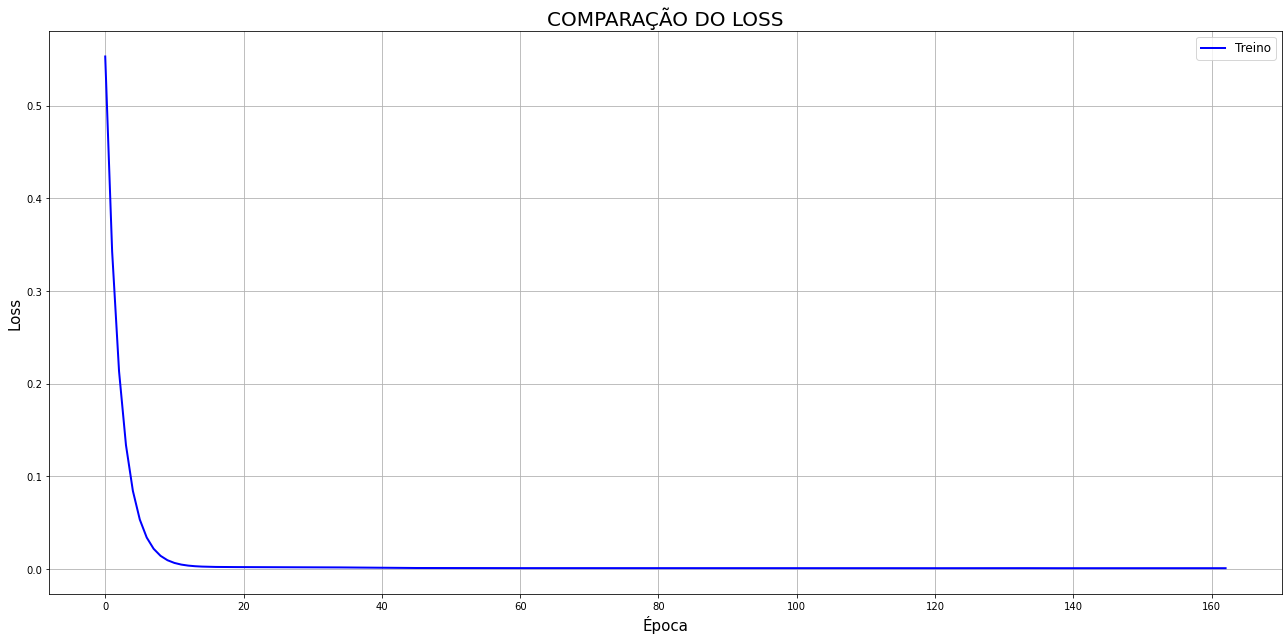

In [35]:
plt.figure(figsize=(18,9))

plt.plot(history.history['loss'], label = "Treino", linewidth =2, color ='blue')        

plt.title('COMPARAÇÃO DO LOSS', fontsize =20)
plt.xlabel('Época', fontsize =15)
plt.ylabel('Loss',fontsize =15)
plt.grid()
plt.legend(fontsize=12)
plt.tight_layout()
# plt.savefig("DEATHS_LSTMCNN_Grafico_de_loss.png", dpi=600)
plt.show()

In [36]:
lb_test = "TRAIN"

if lb_test == "TRAIN":
    observado = y_train
    predicao =  modelo.predict(new_train) 
elif lb_test == "VAL":
    observado = y_val
    predicao =  modelo.predict(new_val) 
elif lb_test == "TEST":
    observado = y_test
    predicao =  modelo.predict(new_test)

In [37]:
predicao = normalizador_y.inverse_transform(predicao)
observado = normalizador_y.inverse_transform(observado)

In [38]:
df_predicao = pd.DataFrame(predicao)
# df_predicao.to_csv("PREDICTION_KFOLD_DEATH_LF30")

In [39]:
predicao.shape

(22044, 30)

In [40]:
observado.shape

(22044, 30)

#### AVALIAÇÃO DO MODELO POR HORIZONTE DE PREDIÇÃO

In [41]:
metricas_qualidade = get_metrics(pd.DataFrame(observado), pd.DataFrame(predicao), filename=lb_test + "_DEATHS_LSTMCNN")
metricas_qualidade

,MSE,RMSE,MAE,Pearson r,Fac2
0,2845.49,53.3431,14.3831,0.922136,0.20078
1,3077.32,55.4736,14.0242,0.914993,0.193522
2,2984.94,54.6346,14.3946,0.918336,0.202277
3,2693.12,51.8953,13.8478,0.927531,0.197423
4,2584.15,50.8345,14.0794,0.931129,0.190573
5,2863,53.507,14.5218,0.923719,0.205362
6,3550.31,59.5845,15.7359,0.904367,0.198058
7,4251.95,65.207,16.887,0.883659,0.204545
8,4753.64,68.9467,17.537,0.869327,0.205634
9,5428.52,73.6785,17.3965,0.854299,0.197968


#### BRASIL

In [42]:
brazil = train_data[train_data['Country/Region'] == 'Brazil'].copy()
x_brazil, y_brazil = generate_regions_dataset(
    key="Country/Region",
    regions_data=brazil,
    look_back=lookback,
    look_forward=lookforward,
    x_columns=x_columns,
    y_columns=y_columns
)

In [43]:
local="Brasil_"
x_brazil_scaled = normalizador.transform(x_brazil)
y_brazil_scaled = normalizador_y.transform(y_brazil)

new_brazil = np.empty([x_brazil_scaled.shape[0], lookback, len(x_columns)])

k = 0
for i in range(len(x_columns)):
    for j in range(lookback):
        new_brazil[:, j, i] = x_brazil_scaled[:, k]
        k = k + 1

y_brazil_pred = modelo.predict(new_brazil)
y_brazil_pred = normalizador_y.inverse_transform(y_brazil_pred)

y_brazil = normalizador_y.inverse_transform(y_brazil_scaled)

y_brazil_pred = pd.DataFrame(y_brazil_pred)
y_brazil = pd.DataFrame(y_brazil)

brazil_metrics = get_metrics(y_brazil, y_brazil_pred)
brazil_metrics

,MSE,RMSE,MAE,Pearson r,Fac2
0,77073.2,277.621,176.474,0.862413,0.676692
1,84344.1,290.421,180.636,0.838387,0.646617
2,78242.7,279.719,170.199,0.855212,0.609023
3,54685,233.848,148.848,0.903728,0.691729
4,40940.7,202.338,136.681,0.931944,0.736842
5,43395.4,208.316,149.346,0.924266,0.729323
6,60374.9,245.713,174.046,0.884232,0.676692
7,79932.2,282.723,199.477,0.83668,0.661654
8,90772.5,301.285,209.636,0.811373,0.616541
9,80114.8,283.046,196,0.829218,0.62406


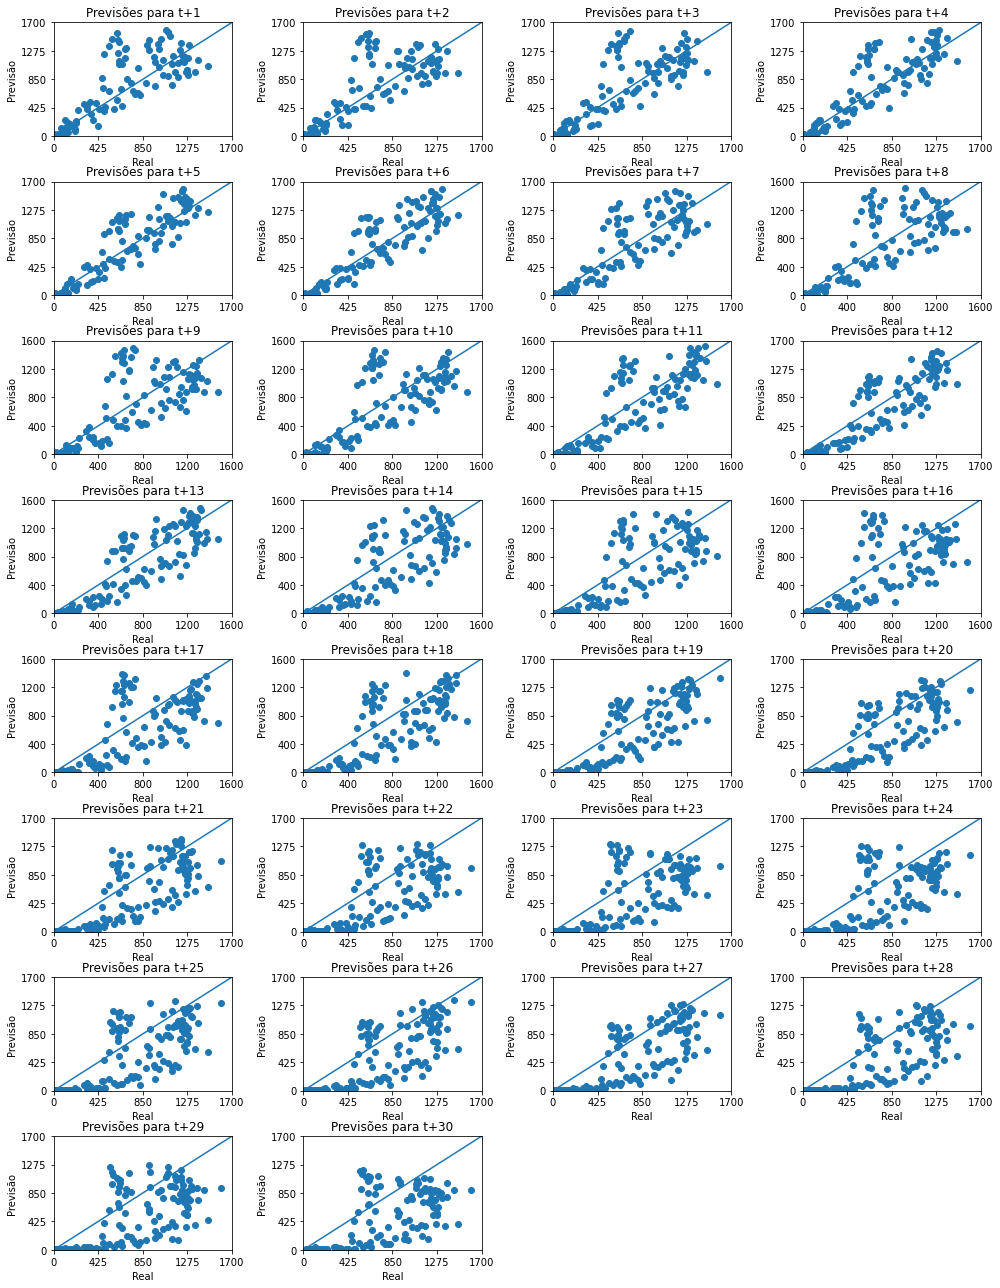

In [44]:
plot_scatter(
    y_brazil,
    y_brazil_pred,
    )

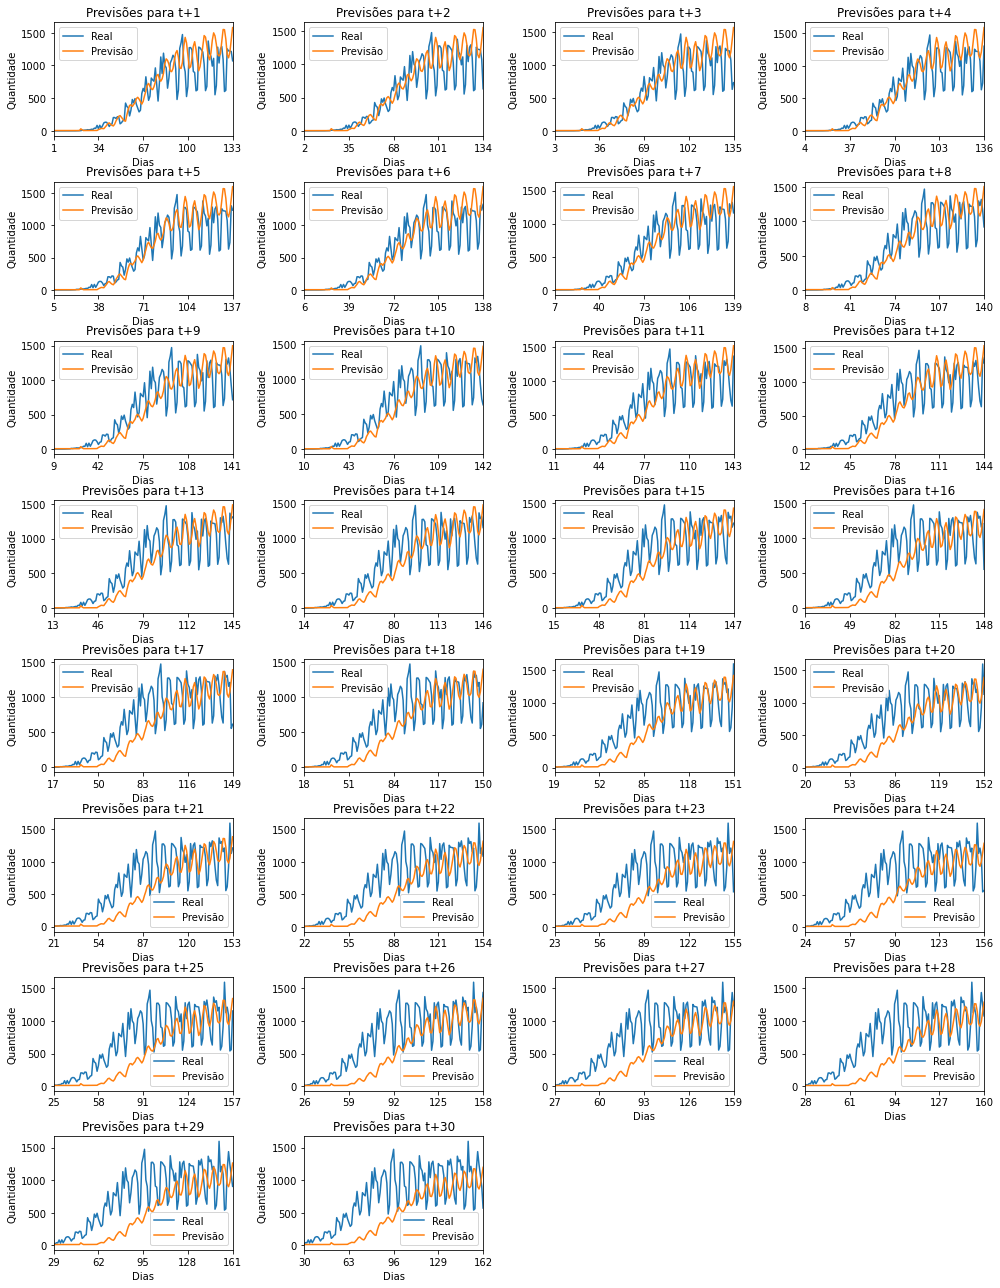

In [45]:
plot_samples(
    y_brazil,
    y_brazil_pred,
   
    xlabel='Dias',
    ylabel='Quantidade'
)

#### BRASIL

In [46]:
bahia = train_data[train_data['Country/Region'] == 'BA'].copy()
x_bahia, y_bahia = generate_regions_dataset(
    key="Country/Region",
    regions_data=bahia,
    look_back=lookback,
    look_forward=lookforward,
    x_columns=x_columns,
    y_columns=y_columns
)

In [47]:
local="Bahia_"
x_bahia_scaled = normalizador.transform(x_bahia)
y_bahia_scaled = normalizador_y.transform(y_bahia)

new_bahia = np.empty([x_bahia_scaled.shape[0], lookback, len(x_columns)])

k = 0
for i in range(len(x_columns)):
    for j in range(lookback):
        new_bahia[:, j, i] = x_bahia_scaled[:, k]
        k = k + 1

y_bahia_pred = modelo.predict(new_bahia)
y_bahia_pred = normalizador_y.inverse_transform(y_bahia_pred)

y_bahia = normalizador_y.inverse_transform(y_bahia_scaled)

y_bahia_pred = pd.DataFrame(y_bahia_pred)
y_bahia = pd.DataFrame(y_bahia)

bahia_metrics = get_metrics(y_bahia, y_bahia_pred)
bahia_metrics

,MSE,RMSE,MAE,Pearson r,Fac2
0,164.233,12.8154,9.53865,0.804474,0.46875
1,185.226,13.6098,9.88513,0.790453,0.460938
2,179.184,13.386,9.9773,0.795072,0.460938
3,198.843,14.1012,10.4539,0.786347,0.453125
4,204.198,14.2898,10.5671,0.787765,0.445312
5,219.26,14.8074,10.8794,0.776498,0.4375
6,216.411,14.7109,10.8975,0.772481,0.476562
7,212.476,14.5766,10.8557,0.773945,0.46875
8,216.238,14.705,11.2701,0.763248,0.507812
9,243.427,15.6021,11.8493,0.755225,0.507812


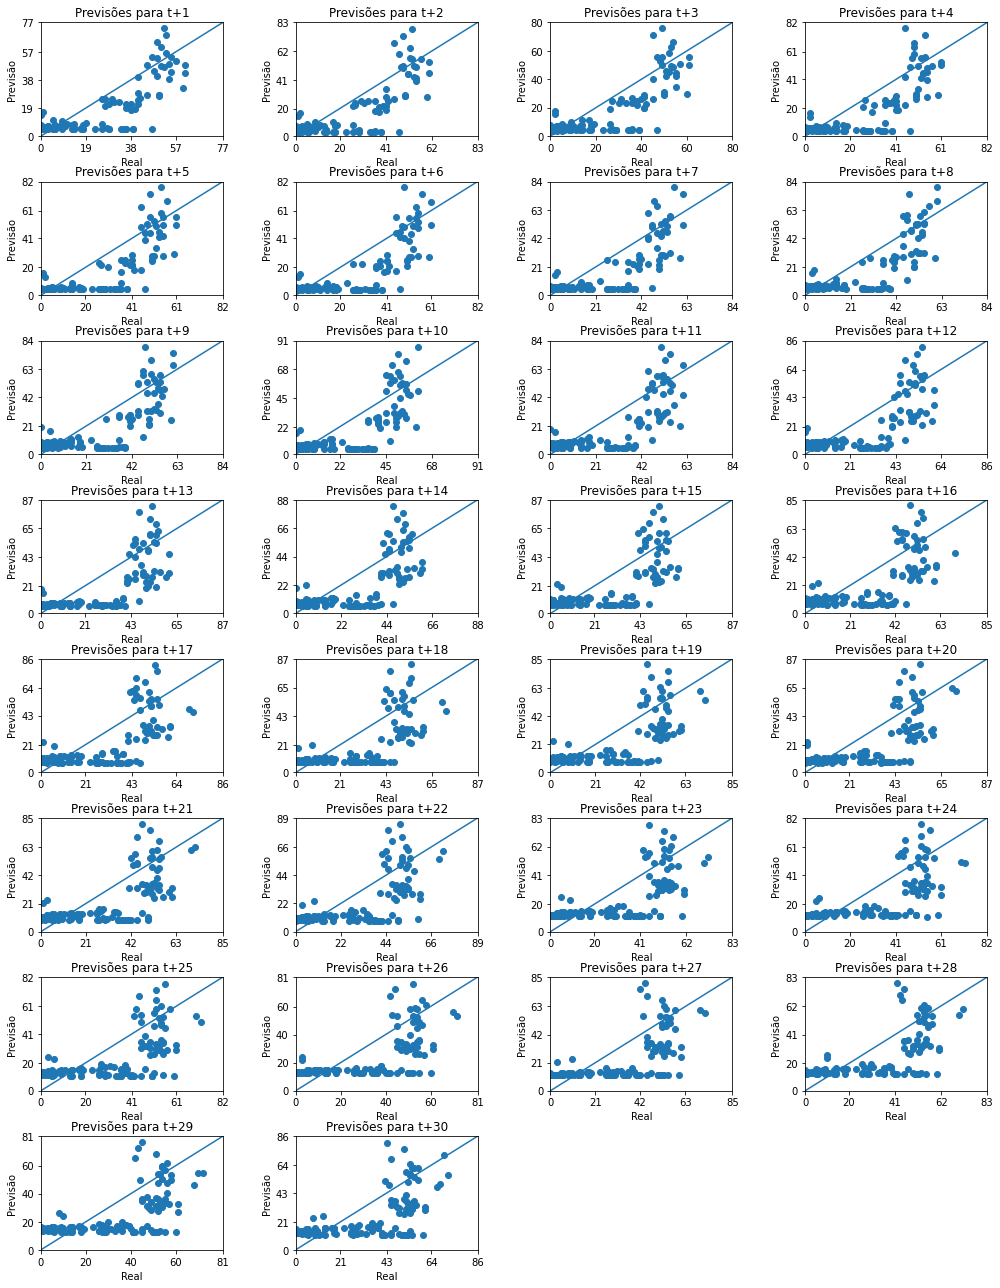

In [48]:
plot_scatter(
    y_bahia,
    y_bahia_pred,
   
)

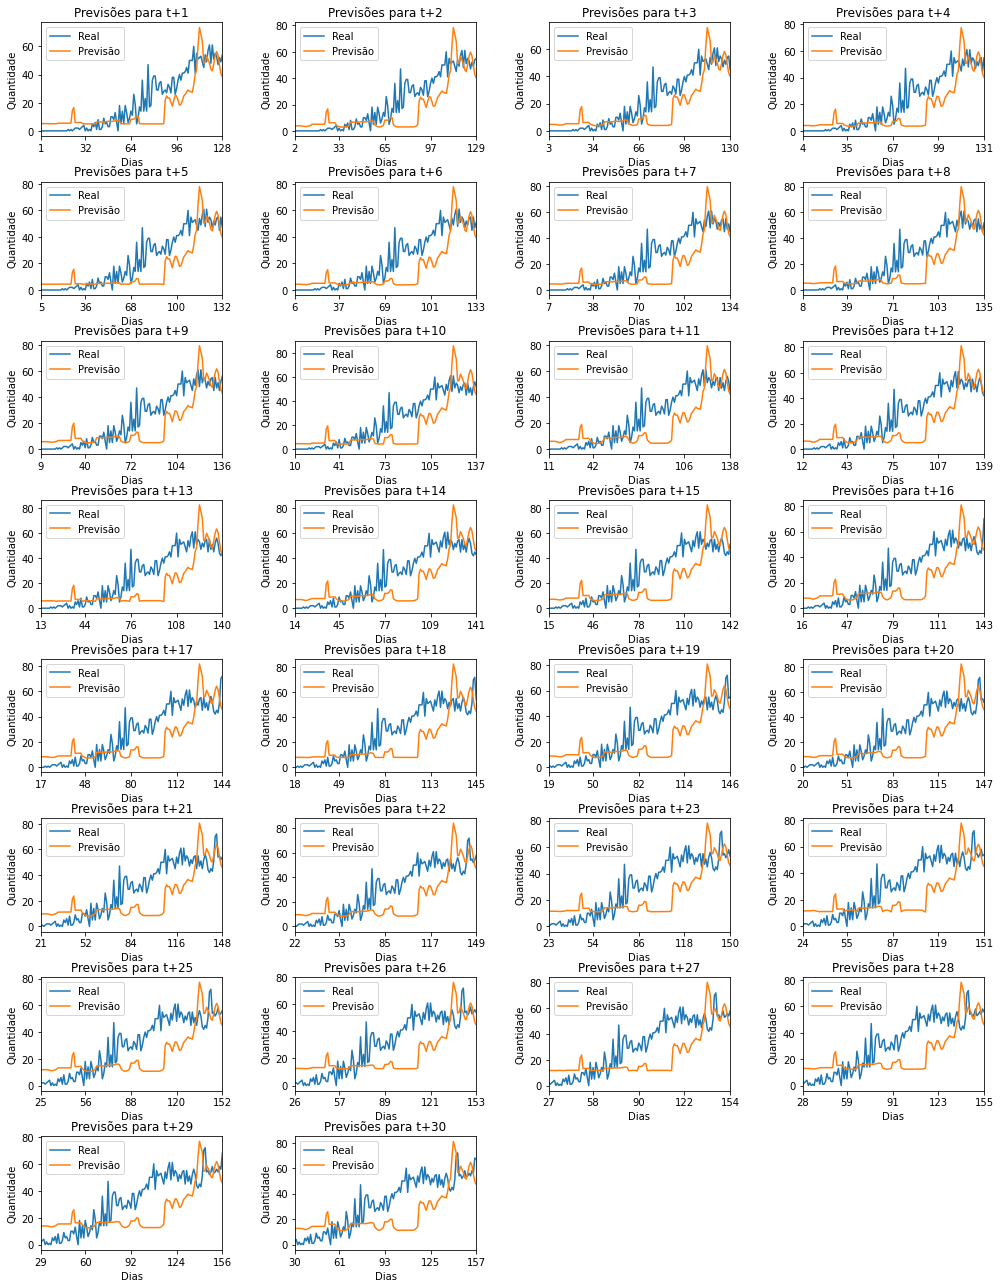

In [49]:
plot_samples(
    y_bahia,
    y_bahia_pred,
    
    xlabel='Dias',
    ylabel='Quantidade'
)